In [11]:
# import useful libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import os
import joblib

In [13]:
# read the dataset
dataset_directory = "../processed/"
data = pd.read_csv(dataset_directory+"aus_kaggle.csv")
inputs = data.drop("Unnamed: 0", axis=1)
inputs = inputs.drop(["input","face","frame"],axis=1)

inputs = inputs.dropna()

inputs.head()

labels = inputs["emotions"]
inputs = inputs.drop("emotions", axis=1).filter(like="AU", axis=1)

In [20]:
len(inputs.columns)

20

In [21]:

# split = 70/20/10
data_in, test_in, data_out, test_out = train_test_split(
    inputs,
    labels,
    test_size=0.1,
    random_state=18,
    stratify=labels,  # balances labels across the sets
)

train_in, val_in, train_out, val_out = train_test_split(
    data_in,
    data_out,
    test_size=(0.2 / 0.9),  # 20% of the original data
    random_state=18,
    stratify=data_out,
)
train_in

,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
12280,0.328112,0.289821,0.819641,0.316017,0.681188,1.0,0.558662,0.845016,0.0,0.801381,0.661904,0.223785,0.404471,1.0,0.454003,0.144476,0.981827,0.115751,0.174034,0.218267
518,0.232960,0.236281,0.651239,0.433959,0.289654,1.0,0.387615,0.231137,1.0,0.367511,0.382906,0.277168,0.277348,1.0,0.473205,0.052158,0.999433,0.480313,0.090135,0.461819
18089,0.376043,0.239927,0.204602,0.640122,0.324266,0.0,0.147478,0.145910,1.0,0.375979,0.639168,0.757384,0.450544,1.0,0.848354,0.802279,0.447579,0.480906,0.719816,0.044644
12120,0.473571,0.539376,0.381317,0.356967,0.753745,1.0,0.484912,0.476416,0.0,0.902387,0.842387,0.186816,0.538403,1.0,0.207250,0.492270,0.657916,0.055295,0.119285,0.240390
23831,0.793477,0.653774,0.672573,0.245938,0.113734,0.0,0.433964,0.013425,0.0,0.056693,0.581131,0.767625,0.610089,0.0,0.725083,0.699132,0.009143,0.117243,0.576528,0.616101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19123,0.270481,0.378139,0.266258,0.702186,0.085326,0.0,0.182618,0.315757,1.0,0.143701,0.293160,0.362020,0.323141,0.0,0.567566,0.546946,0.146443,0.218016,0.302349,0.054923
10748,0.443297,0.112108,0.447879,0.244758,0.786056,0.0,0.644784,0.823755,0.0,0.796277,0.651668,0.531074,0.167521,1.0,0.372677,0.087797,0.997588,0.589782,0.069703,0.822850
2448,0.599679,0.651421,0.177370,0.474944,0.264310,1.0,0.221877,0.000568,1.0,0.276633,0.459031,0.282608,0.378860,1.0,0.389006,0.369966,0.961975,0.487323,0.026509,0.238076
15238,0.432559,0.223279,0.588407,0.318413,0.772365,1.0,0.508822,0.715246,1.0,0.615069,0.601672,0.303364,0.264914,1.0,0.545099,0.098132,0.999895,0.729569,0.052645,0.722661


In [24]:
# Train model 2 svc rbl

from sklearn.preprocessing import StandardScaler

# Create Pipeline with SVC
pipeline = Pipeline(
    [
        # Step 1: Preprocessing - Standardize features
        ("scaler", StandardScaler()),
        # Step 2: Model - Support Vector Classifier
        ("svc", SVC(probability=True)),  # probability=True for prediction probabilities
    ]
)

# Define Hyperparameter Grid for Tuning
param_grid = {
    # Hyperparameters for the SVC
    "svc__C": [0.1, 1, 10, 100],  # Regularization parameter
    "svc__kernel": ["linear", "rbf", "poly"],  # Kernel type
    "svc__gamma": ["scale", "auto", 0.1, 1],  # Kernel coefficient
    "svc__class_weight": [None, "balanced"],  # Handle class imbalance
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    pipeline,  # The pipeline we created
    param_grid,  # Hyperparameter combinations to try
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",  # Metric to evaluate
    n_jobs=-1,  # Use all available cores
)

# Fit the grid search on training data
grid_search.fit(train_in, train_out)

# Best model and parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Validate on validation set
val_score = grid_search.score(val_in, val_out)
print("Validation Set Accuracy:", val_score)

# Final evaluation on test set
test_score = grid_search.score(test_in, test_out)
print("Test Set Accuracy:", test_score)

# Optional: Detailed Classification Report
from sklearn.metrics import classification_report

# Get the best model
best_model = grid_search.best_estimator_

# Predictions on test set
y_pred = best_model.predict(test_in)

# Classification report
print("\nClassification Report:")
print(classification_report(test_out, y_pred))

# Optional: Prediction probabilities
y_pred_proba = best_model.predict_proba(test_in)

KeyboardInterrupt: 

In [4]:
class MachineLearningWorkflow:
    def __init__(self, data_path, target_column):
        """
        Initialize the machine learning workflow

        Args:
            data_path (str): Path to the dataset
            target_column (str): Name of the target column
        """
        self.data_path = data_path
        self.target_column = target_column
        self.data = None
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None

    def prepare_dataset(self, test_size=0.1, val_size=(0.2 / 0.9), random_state=42):
        """
        Prepare the dataset by loading and splitting

        Args:
            test_size (float): Proportion of test set
            val_size (float): Proportion of validation set
            random_state (int): Random seed for reproducibility
        """
        # Load data
        self.data = pd.read_csv(self.data_path)

        # Display class distribution
        print("Class Distribution:")
        print(self.data[self.target_column].value_counts())

        # Separate features and target

        features = self.data.dropna()
        features = features.drop(["input", "face", "frame", "Unnamed: 0"], axis=1)
        labels = features[self.target_column]

        au_columns = [col for col in features.columns if col.startswith("AU")]
        features = features[au_columns]
        print(features)

        

        # First split
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            features,
            labels,
            test_size=test_size,
            random_state=random_state,
            stratify=labels,
        )

        # Second split
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=val_size, random_state=random_state
        )

        return self

    def create_preprocessing_pipeline(self):
        """
        Create a preprocessing pipeline with imputation and scaling

        Returns:
            Pipeline: Preprocessing pipeline
        """
        preprocessing_pipeline = Pipeline(
            [
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )

        return preprocessing_pipeline

    def evaluate_model(self, model, X_val, y_val):
        """
        Evaluate model performance

        Args:
            model: Trained model
            X_val: Validation features
            y_val: Validation labels

        Returns:
            dict: Performance metrics
        """
        y_pred = model.predict(X_val)

        metrics = {
            "accuracy": accuracy_score(y_val, y_pred),
            "precision": precision_score(y_val, y_pred, average="weighted"),
            "recall": recall_score(y_val, y_pred, average="weighted"),
            "f1_score": f1_score(y_val, y_pred, average="weighted"),
        }

        return metrics

    def tune_model_hyperparameters(self, model_class, param_grid):
        """
        Tune hyperparameters for a given model

        Args:
            model_class: Model class to tune
            param_grid (dict): Hyperparameter grid

        Returns:
            RandomizedSearchCV: Best model after hyperparameter tuning
        """
        full_pipeline = Pipeline(
            [
                ("preprocessor", self.create_preprocessing_pipeline()),
                ("classifier", model_class()),
            ]
        )

        random_search = RandomizedSearchCV(
            full_pipeline,
            param_distributions=param_grid,
            n_iter=50,
            cv=5,
            scoring="accuracy",
            random_state=42,
        )

        random_search.fit(self.X_train, self.y_train)

        print(f"Best parameters for {model_class.__name__}:")
        print(random_search.best_params_)

        return random_search

    def train_and_compare_models(self):
        """
        Train multiple models and compare their performance

        Returns:
            dict: Models with their performance metrics
        """
        # Define models and their hyperparameter grids
        models = {
            "RandomForest": {
                "class": RandomForestClassifier,
                "params": {
                    "classifier__n_estimators": [100, 200, 300],
                    "classifier__max_depth": [10, 20, 30, None],
                },
            },
            "SVM": {
                "class": SVC,
                "params": {
                    "classifier__kernel": ["rbf", "poly", "sigmoid"],
                    "classifier__C": [0.1, 1, 10, 100],
                },
            },
            "DecisionTree": {
                "class": DecisionTreeClassifier,
                "params": {
                    "classifier__max_depth": [5, 10, 15, 20],
                    "classifier__min_samples_split": [2, 5, 10],
                },
            },
        }

        model_performances = {}

        for name, model_config in models.items():
            print(f"\nTuning {name} Model")
            tuned_model = self.tune_model_hyperparameters(
                model_config["class"], model_config["params"]
            )

            # Evaluate on validation set
            metrics = self.evaluate_model(
                tuned_model.best_estimator_, self.X_val, self.y_val
            )

            model_performances[name] = {
                "best_model": tuned_model.best_estimator_,
                "metrics": metrics,
            }

        return model_performances

    def select_best_model(self, model_performances):
        """
        Select the best model based on accuracy

        Args:
            model_performances (dict): Dictionary of model performances

        Returns:
            tuple: Best model and its name
        """
        best_model_name = max(
            model_performances,
            key=lambda k: model_performances[k]["metrics"]["accuracy"],
        )

        best_model = model_performances[best_model_name]["best_model"]
        best_accuracy = model_performances[best_model_name]["metrics"]["accuracy"]

        print(f"\nBest Model: {best_model_name}")
        print(f"Validation Accuracy: {best_accuracy:.4f}")

        return best_model, best_model_name

    def save_best_model(self, best_model, best_model_name, save_dir="../model/"):
        """
        Save the best performing model

        Args:
            best_model: Best trained model
            best_model_name (str): Name of the best model
            save_dir (str): Directory to save the model
        """
        os.makedirs(save_dir, exist_ok=True)
        model_filename = f"best_emotion_model_{best_model_name}_kaggle.pkl"
        model_path = os.path.join(save_dir, model_filename)

        joblib.dump(best_model, model_path)
        print(f"Model saved to {model_path}")

In [19]:
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import joblib


workflow = MachineLearningWorkflow(
    data_path=dataset_directory + "aus.csv", target_column="emotions"
)

workflow.prepare_dataset()
model_performances = workflow.train_and_compare_models()
best_model, best_model_name = workflow.select_best_model(model_performances)
workflow.save_best_model(best_model, best_model_name)

Class Distribution:
emotions
neutral     348
happy       340
surprise    182
angry       178
disgust      88
sad          81
fear         72
Name: count, dtype: int64
          AU01      AU02      AU04      AU05      AU06  AU07      AU09  \
0     0.462118  0.187764  0.578946  0.328081  0.538130   1.0  0.535241   
1     0.360411  0.191716  0.247170  0.269536  0.079867   0.0  0.259076   
2     0.183939  0.150695  0.490818  0.274774  0.653131   1.0  0.636941   
3     0.561900  0.431248  0.545331  0.438458  0.145115   0.0  0.367367   
4     0.437871  0.435552  0.651622  0.320687  0.240153   1.0  0.413129   
...        ...       ...       ...       ...       ...   ...       ...   
1284  0.241089  0.370427  0.334878  0.328424  0.122249   0.0  0.330490   
1285  0.397340  0.158596  0.353561  0.404856  0.127621   1.0  0.411720   
1286  0.309860  0.305702  0.351745  0.406746  0.100878   1.0  0.240786   
1287  0.387912  0.216832  0.701315  0.353338  0.193991   0.0  0.504722   
1288  0.346435  0.1

c:\Users\amrit\env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for RandomForestClassifier:
{'classifier__n_estimators': 100, 'classifier__max_depth': 10}


c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Tuning SVM Model


c:\Users\amrit\env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for SVC:
{'classifier__kernel': 'rbf', 'classifier__C': 1}


c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Tuning DecisionTree Model


c:\Users\amrit\env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for DecisionTreeClassifier:
{'classifier__min_samples_split': 10, 'classifier__max_depth': 5}


c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Best Model: SVM
Validation Accuracy: 0.6680
Model saved to ../model/best_emotion_model_SVM_kaggle.pkl


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier


# Create multiple pipelines for different classifiers
def create_pipelines():
    # Base pipeline with standard scaler
    base_pipeline = [("scaler", StandardScaler())]

    # 1. SVM Pipeline
    svm_pipeline = Pipeline(base_pipeline + [("svm", SVC(probability=True))])
    svm_params = {
        "svm__C": [0.1, 1, 10],
        "svm__kernel": ["linear", "rbf"],
        "svm__gamma": ["scale", "auto"],
        "svm__class_weight": ["balanced"],
    }

    # 2. Decision Tree Pipeline
    dt_pipeline = Pipeline(base_pipeline + [("dt", DecisionTreeClassifier())])
    dt_params = {
        "dt__max_depth": [3, 5, 7],
        "dt__min_samples_split": [2, 5],
        "dt__class_weight": ["balanced"],
    }

    # 3. AdaBoost with Decision Tree Pipeline
    ada_dt_pipeline = Pipeline(
        base_pipeline
        + [
            (
                "adaboost",
                AdaBoostClassifier(
                    DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R"
                ),
            )
        ]
    )
    ada_dt_params = {
        "adaboost__n_estimators": [50, 100],
        "adaboost__learning_rate": [0.1, 1.0],
    }

    # 4. Random Forest Pipeline
    rf_pipeline = Pipeline(base_pipeline + [("rf", RandomForestClassifier())])
    rf_params = {
        "rf__n_estimators": [100, 200],
        "rf__max_depth": [3, 5],
        "rf__class_weight": ["balanced"],
    }

    # 5. Neural Network Pipeline
    mlp_pipeline = Pipeline(base_pipeline + [("mlp", MLPClassifier())])
    mlp_params = {
        "mlp__hidden_layer_sizes": [(100,), (100, 50)],
        "mlp__activation": ["relu"],
        "mlp__max_iter": [300],
    }

    return [
        ("SVM", svm_pipeline, svm_params),
        ("Decision Tree", dt_pipeline, dt_params),
        ("AdaBoost-DT", ada_dt_pipeline, ada_dt_params),
        ("Random Forest", rf_pipeline, rf_params),
        ("Neural Network", mlp_pipeline, mlp_params),
    ]


def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test):
    results = {}

    for name, pipeline, params in create_pipelines():
        print(f"\nTraining {name}...")

        # Grid Search with Cross-Validation
        grid_search = GridSearchCV(
            pipeline, params, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
        )

        # Fit the model
        grid_search.fit(X_train, y_train)

        # Store results
        results[name] = {
            "best_params": grid_search.best_params_,
            "best_cv_score": grid_search.best_score_,
            "val_score": grid_search.score(X_val, y_val),
            "test_score": grid_search.score(X_test, y_test),
        }

        # Generate classification report
        y_pred = grid_search.predict(X_test)
        print(f"\n{name} Results:")
        print("Best Parameters:", results[name]["best_params"])
        print("Best CV Score:", results[name]["best_cv_score"])
        print("Validation Score:", results[name]["val_score"])
        print("Test Score:", results[name]["test_score"])
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Save probabilities for potential ensemble
        results[name]["probabilities"] = grid_search.predict_proba(X_test)
        results[name]["model"] = grid_search.best_estimator_

    return results


# Function to create a simple ensemble of best models
def create_ensemble_prediction(results, X_test):
    # Get probabilities from all models
    all_probs = np.array([results[name]["probabilities"] for name in results.keys()])
    # Average the probabilities
    ensemble_probs = np.mean(all_probs, axis=0)
    # Get the class with highest probability
    return np.argmax(ensemble_probs, axis=1)


# Assuming your data is loaded as:
# train_in, train_out, val_in, val_out, test_in, test_out

# Train and evaluate all models
results = train_and_evaluate(
    train_in, train_out,
    val_in, val_out,
    test_in, test_out
)

# Create ensemble predictions
ensemble_predictions = create_ensemble_prediction(results, test_in)




Training SVM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

SVM Results:
Best Parameters: {'svm__C': 0.1, 'svm__class_weight': 'balanced', 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best CV Score: 0.711731843575419
Validation Score: 0.73046875
Test Score: 0.71875

Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.50      0.55        18
     disgust       0.50      0.67      0.57         9
        fear       0.36      0.57      0.44         7
       happy       0.97      0.94      0.95        33
     neutral       0.79      0.74      0.76        35
         sad       0.55      0.75      0.63         8
    surprise       0.71      0.56      0.62        18

    accuracy                           0.72       128
   macro avg       0.64      0.68      0.65       128
weighted avg       0.74      0.72      0.72       128


Training Decision Tree...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Dec

c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       angry       0.23      0.17      0.19        18
     disgust       0.00      0.00      0.00         9
        fear       0.00      0.00      0.00         7
       happy       0.97      0.97      0.97        33
     neutral       0.74      0.71      0.72        35
         sad       0.18      0.88      0.30         8
    surprise       0.44      0.22      0.30        18

    accuracy                           0.55       128
   macro avg       0.37      0.42      0.35       128
weighted avg       0.56      0.55      0.54       128


Training AdaBoost-DT...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\amrit\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



AdaBoost-DT Results:
Best Parameters: {'adaboost__learning_rate': 1.0, 'adaboost__n_estimators': 100}
Best CV Score: 0.44469273743016763
Validation Score: 0.57421875
Test Score: 0.609375

Classification Report:


c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       angry       0.21      0.33      0.26        18
     disgust       0.00      0.00      0.00         9
        fear       0.00      0.00      0.00         7
       happy       0.94      0.97      0.96        33
     neutral       0.67      0.69      0.68        35
         sad       0.40      0.25      0.31         8
    surprise       0.67      0.78      0.72        18

    accuracy                           0.61       128
   macro avg       0.41      0.43      0.42       128
weighted avg       0.57      0.61      0.59       128


Training Random Forest...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Random Forest Results:
Best Parameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 5, 'rf__n_estimators': 200}
Best CV Score: 0.7027932960893855
Validation Score: 0.69140625
Test Score: 0.625

Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.17    

c:\Users\amrit\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Network Results:
Best Parameters: {'mlp__activation': 'relu', 'mlp__hidden_layer_sizes': (100,), 'mlp__max_iter': 300}
Best CV Score: 0.7340782122905029
Validation Score: 0.734375
Test Score: 0.640625

Classification Report:
              precision    recall  f1-score   support

       angry       0.33      0.33      0.33        18
     disgust       0.40      0.44      0.42         9
        fear       0.40      0.29      0.33         7
       happy       0.91      0.91      0.91        33
     neutral       0.66      0.77      0.71        35
         sad       0.75      0.75      0.75         8
    surprise       0.54      0.39      0.45        18

    accuracy                           0.64       128
   macro avg       0.57      0.55      0.56       128
weighted avg       0.63      0.64      0.63       128



Starting Grid Search...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\amrit\env\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Grid Search completed!

Best Parameters: {'adaboost__estimator__C': 10, 'adaboost__estimator__gamma': 'scale', 'adaboost__estimator__kernel': 'rbf', 'adaboost__learning_rate': 0.1, 'adaboost__n_estimators': 50}
Best Cross-Validation Score: 0.6648111153509461

Training Set Performance:
              precision    recall  f1-score   support

       angry       0.73      0.77      0.75       124
     disgust       1.00      0.26      0.42        61
        fear       1.00      0.25      0.40        48
       happy       0.99      1.00      0.99       236
         sad       0.68      0.99      0.81       242
    surprise       1.00      0.23      0.37        57
     neutral       0.80      0.84      0.82       127

    accuracy                           0.80       895
   macro avg       0.89      0.62      0.65       895
weighted avg       0.84      0.80      0.77       895


Test Set Performance:


c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       angry       0.62      0.44      0.52        18
     disgust       0.00      0.00      0.00         9
        fear       0.00      0.00      0.00         7
       happy       0.84      0.97      0.90        33
         sad       0.53      0.86      0.65        35
    surprise       0.00      0.00      0.00         8
     neutral       0.68      0.72      0.70        18

    accuracy                           0.65       128
   macro avg       0.38      0.43      0.40       128
weighted avg       0.54      0.65      0.58       128


Overfitting Analysis:
Training Accuracy: 0.802
Test Accuracy: 0.648
Accuracy Difference (Train - Test): 0.154


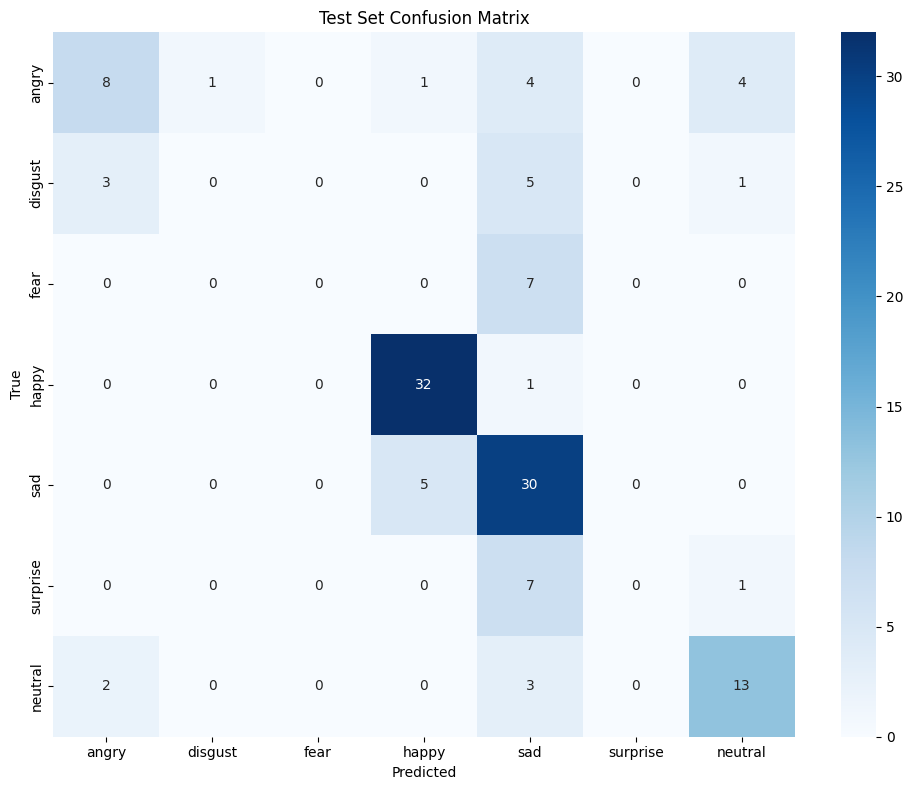

c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amrit\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Set Per-class Performance:
    Emotion  Precision  Recall     F1
0     angry      0.615   0.444  0.516
1   disgust      0.000   0.000  0.000
2      fear      0.000   0.000  0.000
3     happy      0.842   0.970  0.901
4       sad      0.526   0.857  0.652
5  surprise      0.000   0.000  0.000
6   neutral      0.684   0.722  0.703

Class Distribution (Test Set):


C:\Users\amrit\AppData\Local\Temp\ipykernel_17540\1369503305.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{emotion}: {test_dist[i]} samples ({test_dist[i]/len(y_test)*100:.1f}%)"


angry: 18 samples (14.1%)
disgust: 9 samples (7.0%)
fear: 7 samples (5.5%)
happy: 33 samples (25.8%)
sad: 35 samples (27.3%)
surprise: 8 samples (6.2%)
neutral: 18 samples (14.1%)


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


def create_and_train_model(X_train, y_train):
    """
    Create and train the AdaBoost SVC pipeline with optimized grid search
    """
    # Create Pipeline with AdaBoosted SVC
    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "adaboost",
                AdaBoostClassifier(estimator=SVC(probability=True), n_estimators=50),
            ),
        ]
    )

    # Reduced parameter grid for faster execution
    param_grid = {
        # Reduced SVC parameters
        "adaboost__estimator__C": [1, 10],  # Removed 0.1 and 100
        "adaboost__estimator__kernel": ["rbf"],  # Only using RBF kernel
        "adaboost__estimator__gamma": ["scale"],  # Only using scale
        # Reduced AdaBoost parameters
        "adaboost__n_estimators": [50, 100],  # Removed 200
        "adaboost__learning_rate": [0.1, 1.0],  # Removed 0.01
    }

    # Grid Search with Cross-Validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,  # Reduced from 5 to 3 folds
        scoring="accuracy",
        n_jobs=-1,
        verbose=1,
    )

    # Fit the grid search
    print("Starting Grid Search...")
    grid_search.fit(X_train, y_train)
    print("Grid Search completed!")

    return grid_search


def evaluate_emotion_classifier(
    model, X_train, y_train, X_test, y_test, emotion_labels
):
    """
    Streamlined evaluation of the emotion classifier
    """
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Get prediction probabilities
    y_train_proba = model.predict_proba(X_train)
    y_test_proba = model.predict_proba(X_test)

    # 1. Print classification reports
    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred, target_names=emotion_labels))
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_test_pred, target_names=emotion_labels))

    # 2. Calculate accuracy differences to check for overfitting
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    print("\nOverfitting Analysis:")
    print(f"Training Accuracy: {train_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")
    print(f"Accuracy Difference (Train - Test): {train_acc - test_acc:.3f}")

    # 3. Plot confusion matrix for test set only
    plt.figure(figsize=(10, 8))
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(
        cm_test,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=emotion_labels,
        yticklabels=emotion_labels,
    )
    plt.title("Test Set Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # 4. Per-class performance comparison (Test set only)
    test_report = classification_report(
        y_test, y_test_pred, target_names=emotion_labels, output_dict=True
    )

    comparison_data = []
    for emotion in emotion_labels:
        comparison_data.append(
            {
                "Emotion": emotion,
                "Precision": test_report[emotion]["precision"],
                "Recall": test_report[emotion]["recall"],
                "F1": test_report[emotion]["f1-score"],
            }
        )

    comparison_df = pd.DataFrame(comparison_data)
    print("\nTest Set Per-class Performance:")
    print(comparison_df.round(3))

    # 5. Check for class imbalance
    print("\nClass Distribution (Test Set):")
    test_dist = pd.Series(y_test).value_counts().sort_index()

    for i, emotion in enumerate(emotion_labels):
        print(
            f"{emotion}: {test_dist[i]} samples ({test_dist[i]/len(y_test)*100:.1f}%)"
        )


def main():
    # Train the model
    grid_search = create_and_train_model(train_in, train_out)

    # Print best parameters and score
    print("\nBest Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Score:", grid_search.best_score_)

    # Get the best model
    best_model = grid_search.best_estimator_
    emotion_labels = [
        "angry",
        "disgust",
        "fear",
        "happy",
        "sad",
        "surprise",
        "neutral",
    ]  # adjust these based on your actual labels
    # Evaluate the model
    evaluate_emotion_classifier(
        best_model, train_in, train_out, test_in, test_out, emotion_labels
    )


main()

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import joblib
import os
import json
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif


class MachineLearningWorkflow:
    def __init__(self, train_in, val_in, test_in, train_out, val_out, test_out):
        """
        Initialize the machine learning workflow with pre-split data
        Args:
            train_in: Training input features
            val_in: Validation input features
            test_in: Test input features
            train_out: Training labels
            val_out: Validation labels
            test_out: Test labels
        """
        self.X_train = train_in
        self.X_val = val_in
        self.X_test = test_in
        self.y_train = train_out
        self.y_val = val_out
        self.y_test = test_out

    def plot_class_distribution(self):
        """
        Plot the class distribution across train/val/test sets
        """
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        sns.countplot(x=self.y_train)
        plt.title("Training Set Class Distribution")
        plt.xticks(rotation=45)

        plt.subplot(132)
        sns.countplot(x=self.y_val)
        plt.title("Validation Set Class Distribution")
        plt.xticks(rotation=45)

        plt.subplot(133)
        sns.countplot(x=self.y_test)
        plt.title("Test Set Class Distribution")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    def create_preprocessing_pipeline(self):
        """
        Create a preprocessing pipeline with imputation and scaling
        """
        preprocessing_pipeline = Pipeline(
            [
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
        return preprocessing_pipeline

    def plot_learning_curves(self, model, title):
        """
        Plot learning curves to check for overfitting
        """
        train_sizes, train_scores, val_scores = learning_curve(
            model,
            self.X_train,
            self.y_train,
            cv=5,
            train_sizes=np.linspace(0.1, 1.0, 10),
        )

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training score")
        plt.plot(
            train_sizes, np.mean(val_scores, axis=1), label="Cross-validation score"
        )
        plt.xlabel("Training Examples")
        plt.ylabel("Score")
        plt.title(f"Learning Curves - {title}")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, title):
        """
        Plot confusion matrix
        """
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {title}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    def evaluate_model(self, model, X_val, y_val, plot_title="Validation Set"):
        """
        Evaluate model performance with visualizations
        """
        y_pred = model.predict(X_val)
        metrics = {
            "accuracy": accuracy_score(y_val, y_pred),
            "precision": precision_score(y_val, y_pred, average="weighted"),
            "recall": recall_score(y_val, y_pred, average="weighted"),
            "f1_score": f1_score(y_val, y_pred, average="weighted"),
        }

        # Plot confusion matrix
        self.plot_confusion_matrix(y_val, y_pred, plot_title)

        return metrics

    def tune_model_hyperparameters(self, model_class, param_grid):
        """
        Tune hyperparameters with cross-validation
        """
        full_pipeline = Pipeline(
            [
                ("preprocessor", self.create_preprocessing_pipeline()),
                ("classifier", model_class()),
            ]
        )

        random_search = RandomizedSearchCV(
            full_pipeline,
            param_distributions=param_grid,
            n_iter=50,
            cv=5,
            scoring=[
                "accuracy",
                "precision_weighted",
                "recall_weighted",
                "f1_weighted",
            ],
            refit="accuracy",
            random_state=42,
            n_jobs=-1,
        )

        random_search.fit(self.X_train, self.y_train)

        # Plot learning curves for best model
        self.plot_learning_curves(random_search.best_estimator_, model_class.__name__)

        print(f"Best parameters for {model_class.__name__}:")
        print(random_search.best_params_)
        print("\nCross-validation scores:")
        for metric in random_search.scoring:
            print(
                f"{metric}: {random_search.cv_results_[f'mean_test_{metric}'][random_search.best_index_]:.4f}"
            )

        return random_search

    def train_and_compare_models(self):
        """
        Train and compare models with enhanced parameters
        """
        # Plot initial class distributions
        self.plot_class_distribution()

        models = {
            "RandomForest": {
                "class": RandomForestClassifier,
                "params": {
                    "classifier__n_estimators": [100, 200, 300, 400],
                    "classifier__max_depth": [10, 20, 30, None],
                    "classifier__min_samples_split": [2, 5, 10],
                    "classifier__max_features": ["sqrt", "log2"],
                    "classifier__class_weight": ["balanced", "balanced_subsample"],
                },
            },
            "SVM": {
                "class": SVC,
                "params": {
                    "classifier__kernel": ["rbf", "poly"],
                    "classifier__C": [0.1, 1, 10, 100],
                    "classifier__gamma": ["scale", "auto"],
                    "classifier__class_weight": ["balanced"],
                },
            },
            "DecisionTree": {
                "class": DecisionTreeClassifier,
                "params": {
                    "classifier__max_depth": [5, 10, 15, 20],
                    "classifier__min_samples_split": [2, 5, 10],
                    "classifier__min_samples_leaf": [1, 2, 4],
                    "classifier__class_weight": ["balanced"],
                },
            },
        }

        model_performances = {}
        for name, model_config in models.items():
            print(f"\nTuning {name} Model")
            tuned_model = self.tune_model_hyperparameters(
                model_config["class"], model_config["params"]
            )
            metrics = self.evaluate_model(
                tuned_model.best_estimator_, self.X_val, self.y_val
            )
            model_performances[name] = {
                "best_model": tuned_model.best_estimator_,
                "metrics": metrics,
            }

        # Plot comparison of model performances
        self.plot_model_comparison(model_performances)

        return model_performances

    def plot_model_comparison(self, model_performances):
        """
        Plot comparison of model performances
        """
        metrics_df = pd.DataFrame(
            {
                model_name: performance["metrics"]
                for model_name, performance in model_performances.items()
            }
        ).T

        plt.figure(figsize=(12, 6))
        metrics_df.plot(kind="bar")
        plt.title("Model Performance Comparison")
        plt.xlabel("Model")
        plt.ylabel("Score")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

    def select_best_model(self, model_performances):
        """
        Select the best model based on accuracy
        """
        best_model_name = max(
            model_performances,
            key=lambda k: model_performances[k]["metrics"]["accuracy"],
        )
        best_model = model_performances[best_model_name]["best_model"]
        best_accuracy = model_performances[best_model_name]["metrics"]["accuracy"]

        print(f"\nBest Model: {best_model_name}")
        print(f"Validation Accuracy: {best_accuracy:.4f}")

        # Evaluate on test set
        test_metrics = self.evaluate_model(
            best_model, self.X_test, self.y_test, "Test Set"
        )
        print("\nTest Set Metrics:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")

        return best_model, best_model_name

    def save_best_model(self, best_model, best_model_name, save_dir="../model/"):
        """
        Save the best performing model and its metadata
        """
        os.makedirs(save_dir, exist_ok=True)

        # Save model
        model_filename = f"best_emotion_model_{best_model_name}_kaggle.pkl"
        model_path = os.path.join(save_dir, model_filename)
        joblib.dump(best_model, model_path)

        # Save model metadata
        metadata = {
            "model_name": best_model_name,
            "creation_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
            "feature_count": self.X_train.shape[1],
            "training_samples": self.X_train.shape[0],
            "validation_metrics": self.evaluate_model(
                best_model, self.X_val, self.y_val
            ),
            "test_metrics": self.evaluate_model(best_model, self.X_test, self.y_test),
        }

        metadata_filename = f"best_emotion_model_{best_model_name}_metadata.json"
        metadata_path = os.path.join(save_dir, metadata_filename)

        with open(metadata_path, "w") as f:
            json.dump(metadata, f, indent=4)

        print(f"Model saved to {model_path}")
        print(f"Model metadata saved to {metadata_path}")

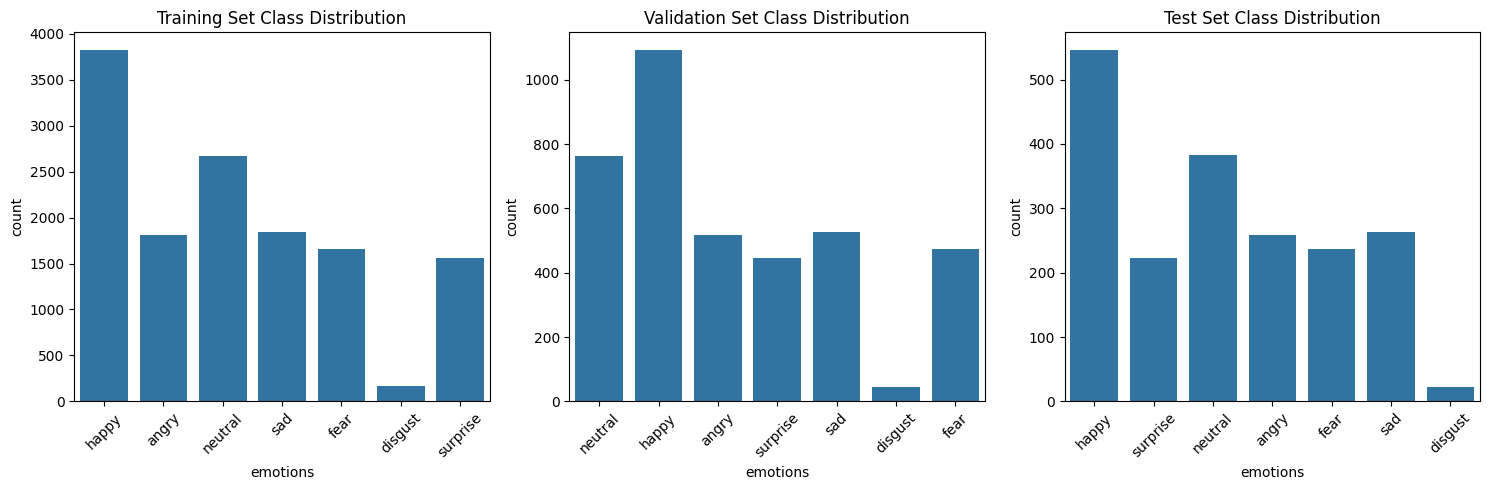

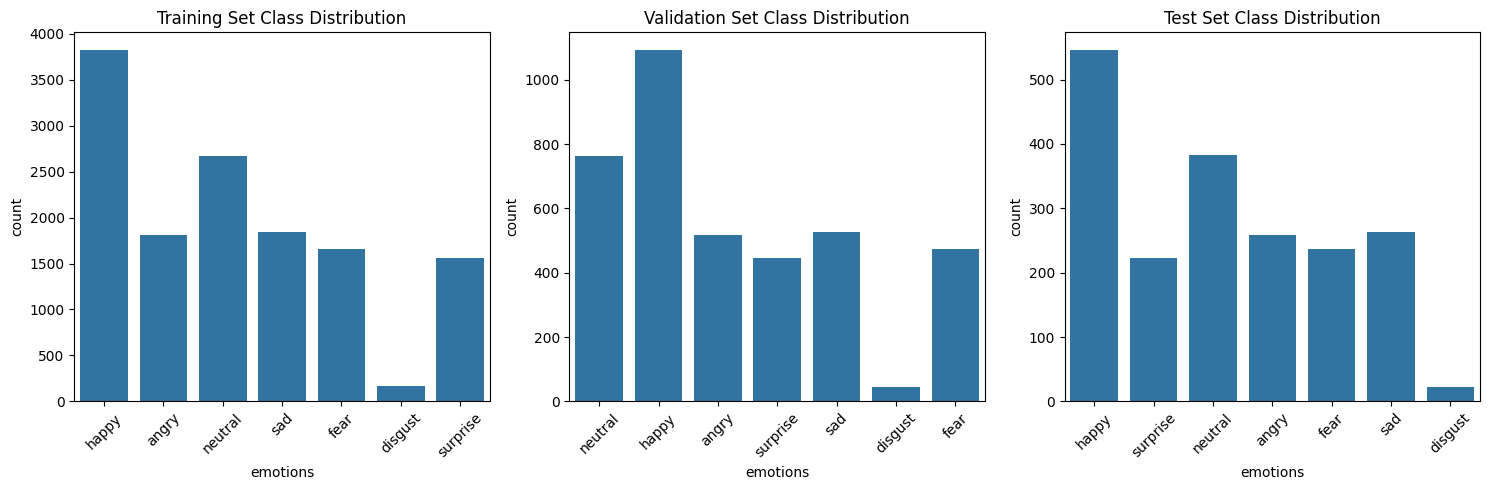


Tuning RandomForest Model


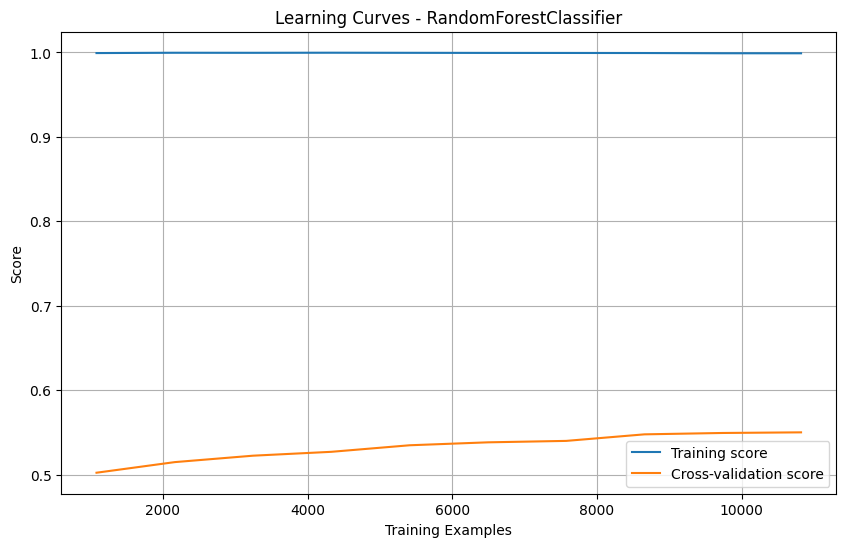

Best parameters for RandomForestClassifier:
{'classifier__n_estimators': 400, 'classifier__min_samples_split': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 20, 'classifier__class_weight': 'balanced_subsample'}

Cross-validation scores:
accuracy: 0.5520
precision_weighted: 0.5580
recall_weighted: 0.5520
f1_weighted: 0.5226


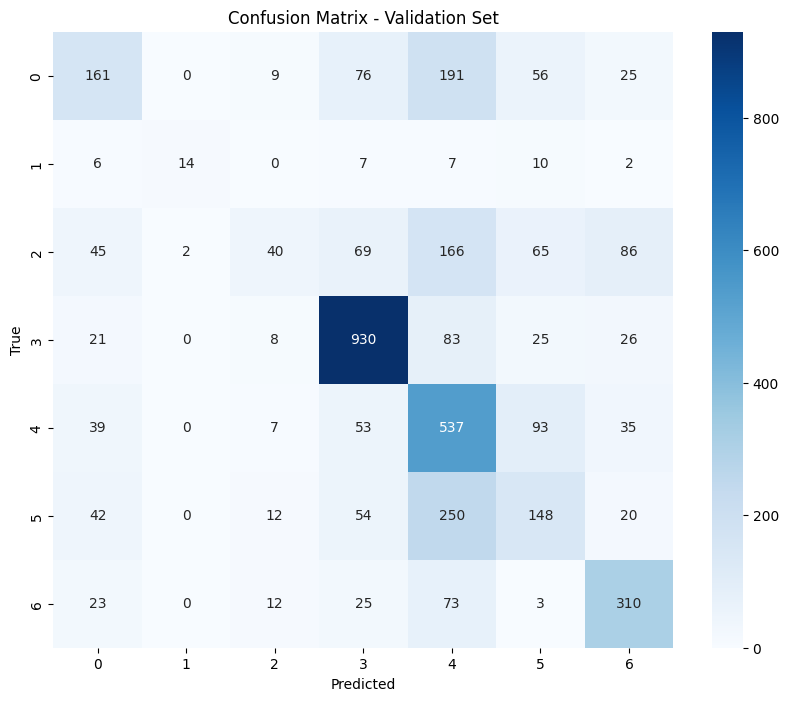


Tuning SVM Model


c:\Users\amrit\env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


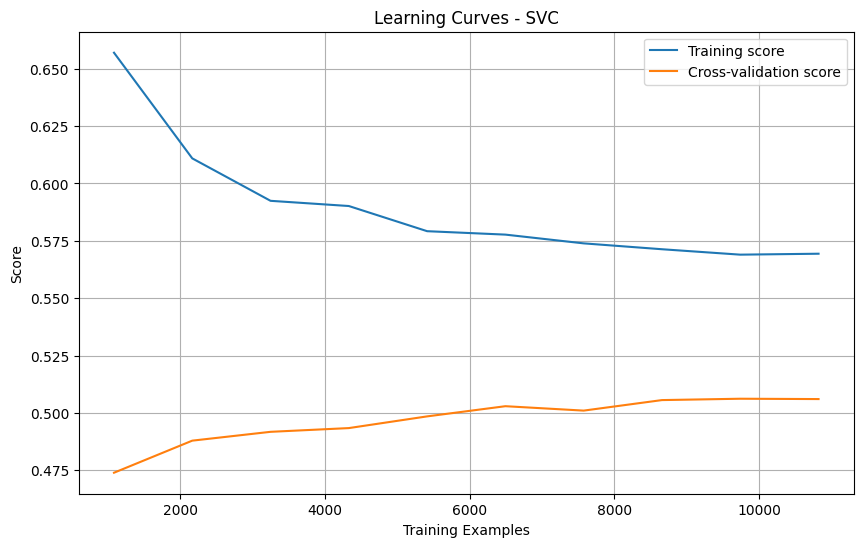

Best parameters for SVC:
{'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 1}

Cross-validation scores:
accuracy: 0.5063
precision_weighted: 0.4994
recall_weighted: 0.5063
f1_weighted: 0.4936


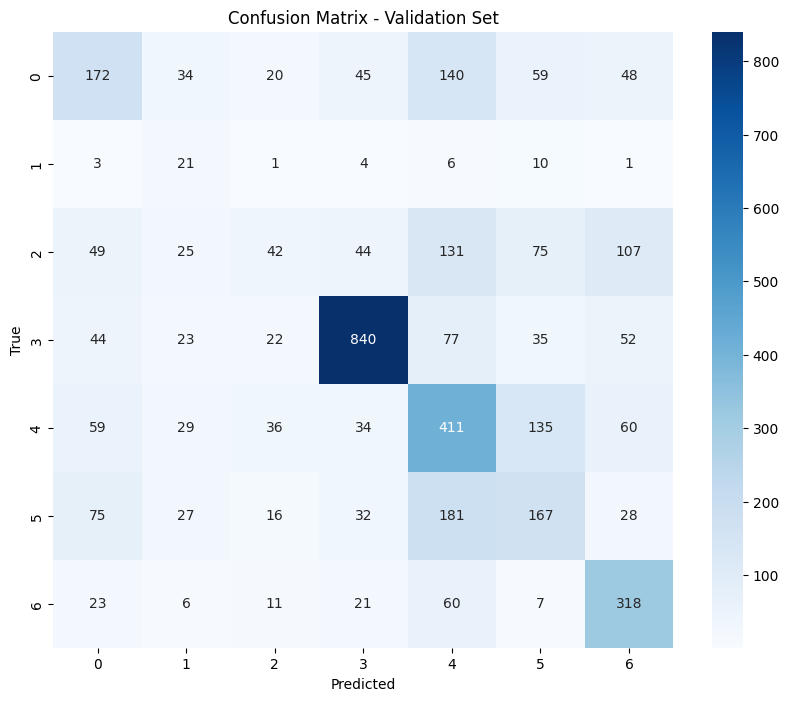


Tuning DecisionTree Model


c:\Users\amrit\env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


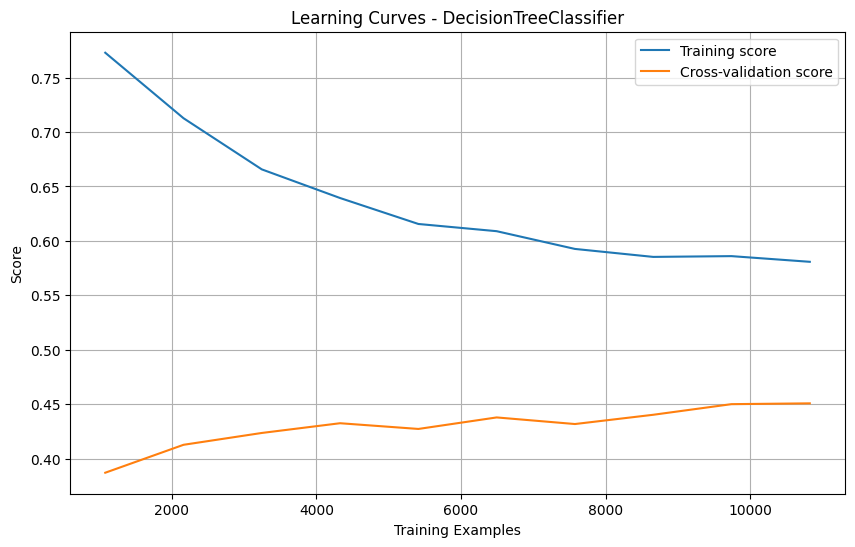

Best parameters for DecisionTreeClassifier:
{'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 10, 'classifier__class_weight': 'balanced'}

Cross-validation scores:
accuracy: 0.4492
precision_weighted: 0.4648
recall_weighted: 0.4492
f1_weighted: 0.4517


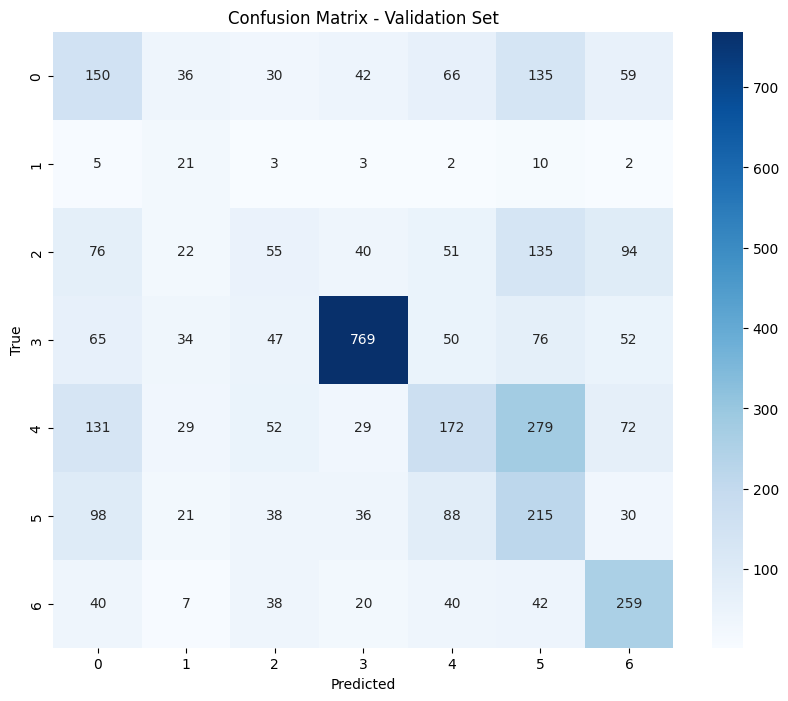

<Figure size 1200x600 with 0 Axes>

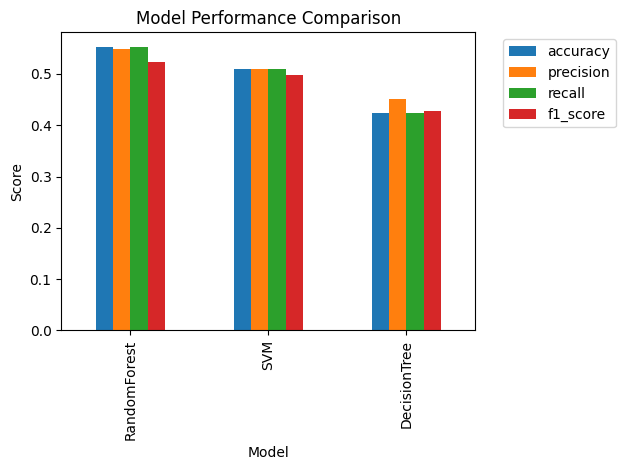


Best Model: RandomForest
Validation Accuracy: 0.5535


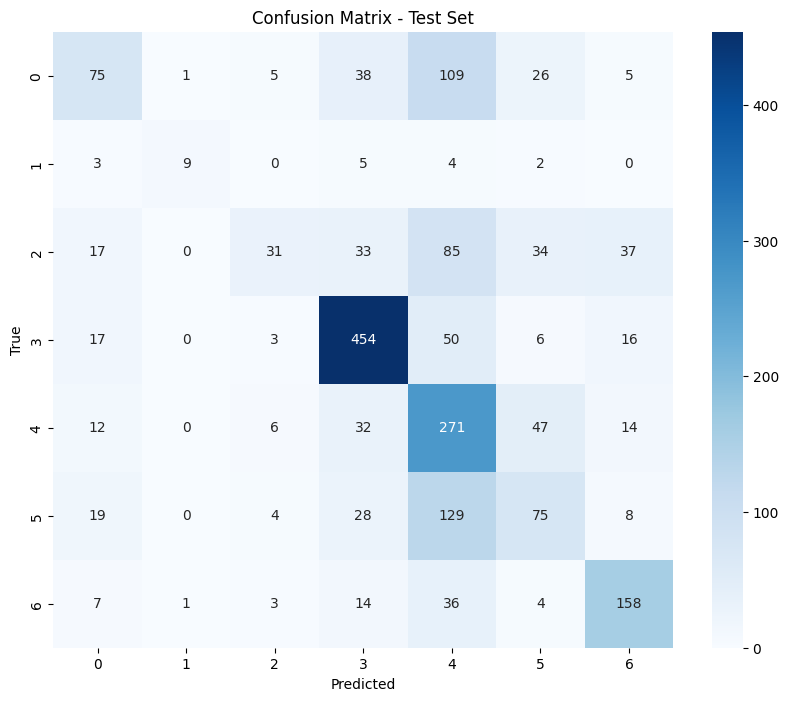


Test Set Metrics:
accuracy: 0.5551
precision: 0.5696
recall: 0.5551
f1_score: 0.5290


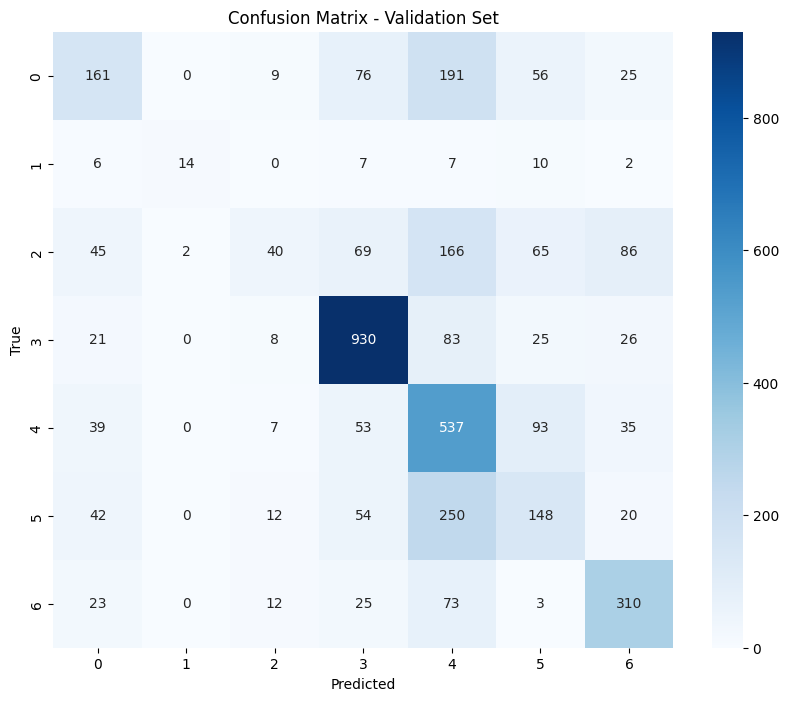

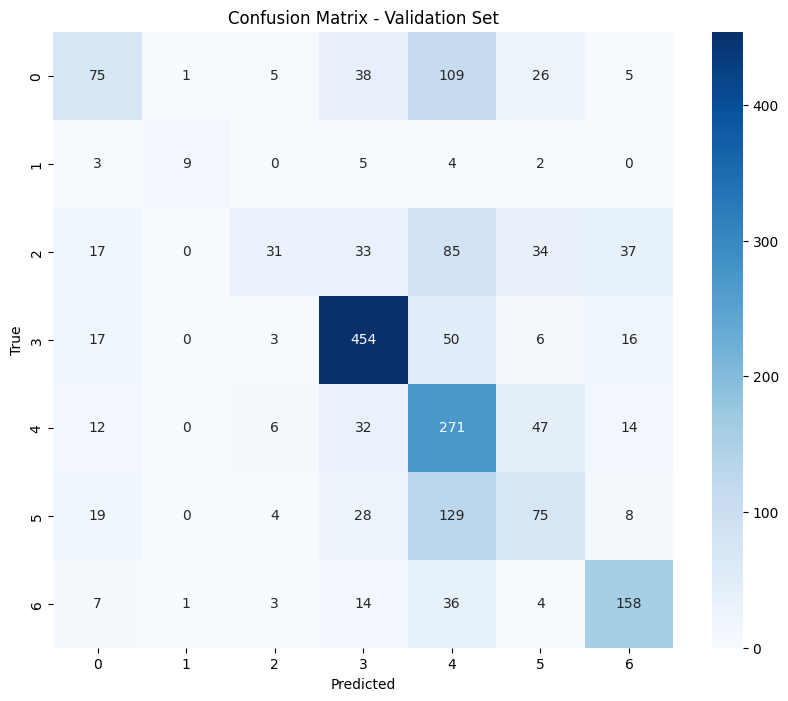

Model saved to ../model/best_emotion_model_RandomForest_kaggle.pkl
Model metadata saved to ../model/best_emotion_model_RandomForest_metadata.json


In [24]:
# Initialize the workflow with your split data
workflow = MachineLearningWorkflow(
    train_in=train_in,
    val_in=val_in,
    test_in=test_in,
    train_out=train_out,
    val_out=val_out,
    test_out=test_out,
)

# Step 1: Visualize class distribution across train/val/test sets
workflow.plot_class_distribution()

# Step 2: Train and compare all models
# This will:
# - Train RandomForest, SVM, and Decision Tree
# - Perform hyperparameter tuning
# - Plot learning curves
# - Show confusion matrices
# - Display cross-validation scores
model_performances = workflow.train_and_compare_models()

# Step 3: Select the best performing model
# This will:
# - Choose the best model based on validation accuracy
# - Evaluate it on the test set
# - Show final performance metrics
best_model, best_model_name = workflow.select_best_model(model_performances)

# Step 4: Save the best model and its metadata
workflow.save_best_model(
    best_model=best_model,
    best_model_name=best_model_name,
    save_dir="../model/",  # adjust this path as needed
)


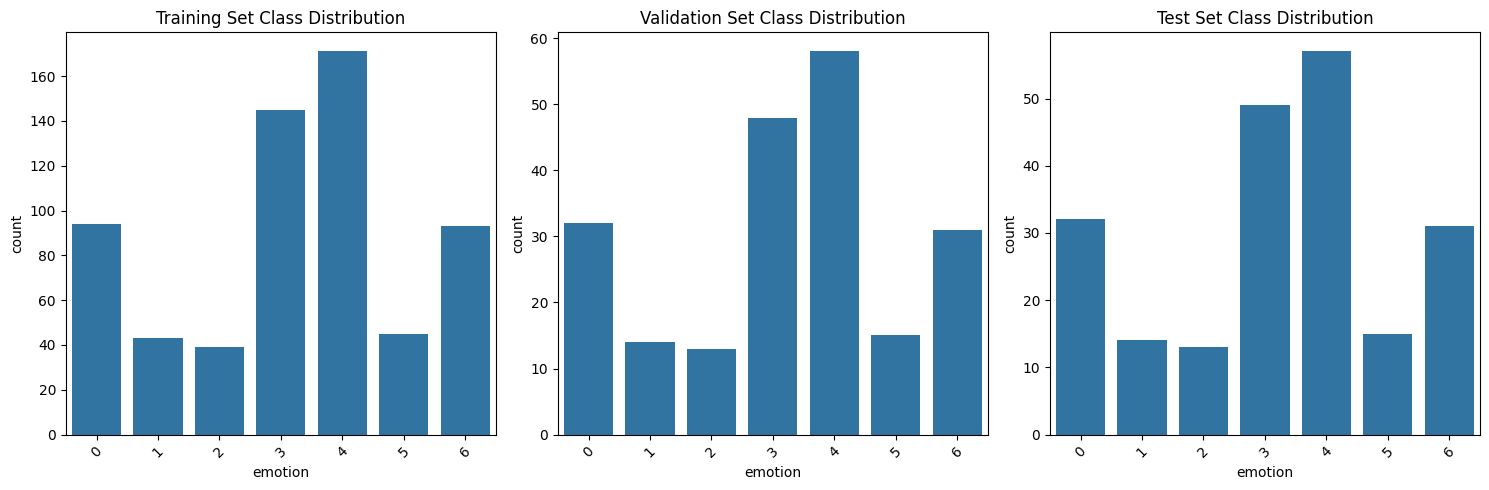


Tuning RandomForest Model


c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-pa

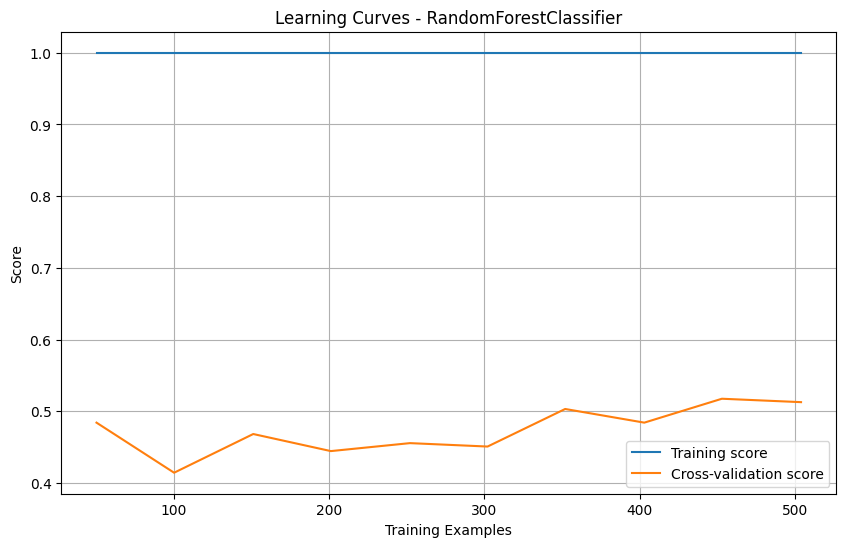

Best parameters for RandomForestClassifier:
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_leaf_nodes': None, 'classifier__max_features': 'log2', 'classifier__max_depth': 20, 'classifier__class_weight': 'balanced'}

Cross-validation scores:
accuracy: 0.5238
precision_weighted: 0.4894
recall_weighted: 0.5238
f1_weighted: 0.4754


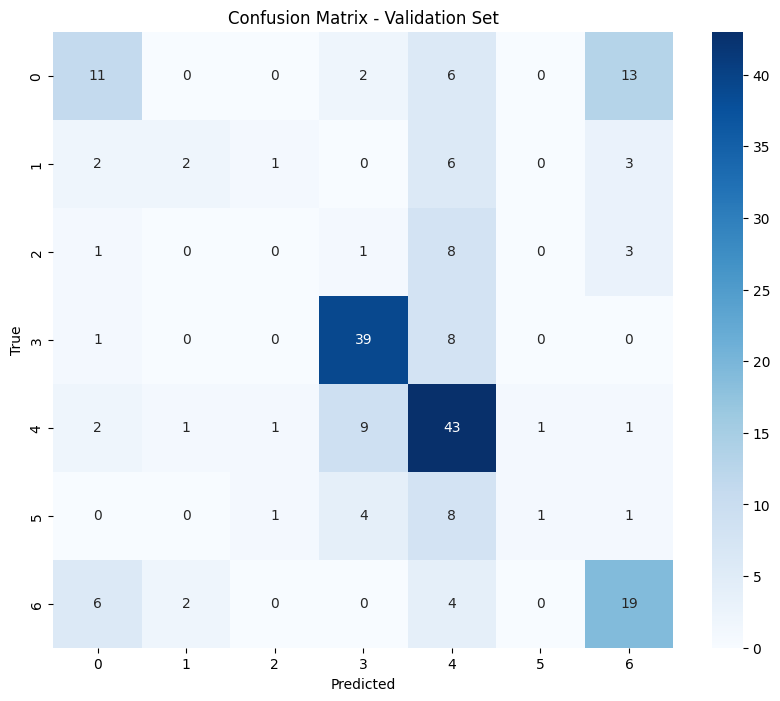

c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-pa

Training Accuracy: 0.5143 ± 0.0277
Validation Accuracy: 0.5022 ± 0.0649
The model is not overfitting.

Tuning SVM Model


c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-pa

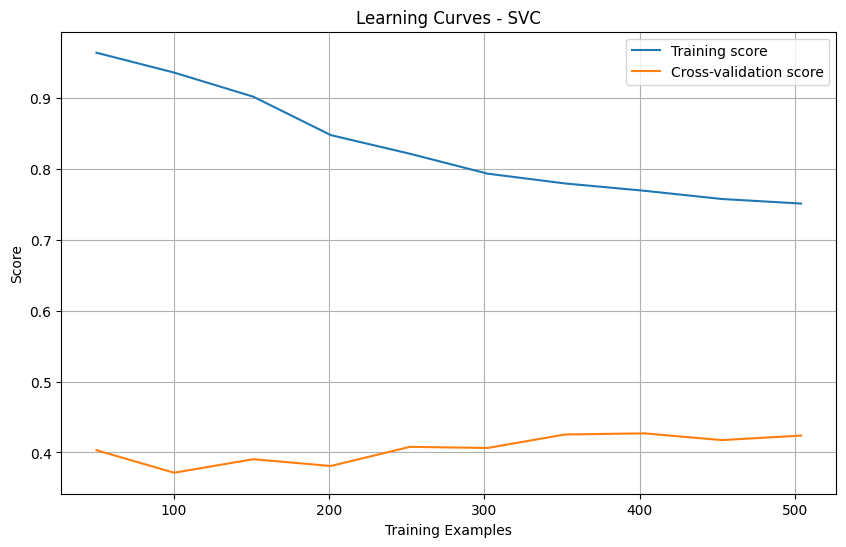

Best parameters for SVC:
{'classifier__probability': True, 'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 10}

Cross-validation scores:
accuracy: 0.4238
precision_weighted: 0.4651
recall_weighted: 0.4238
f1_weighted: 0.4326


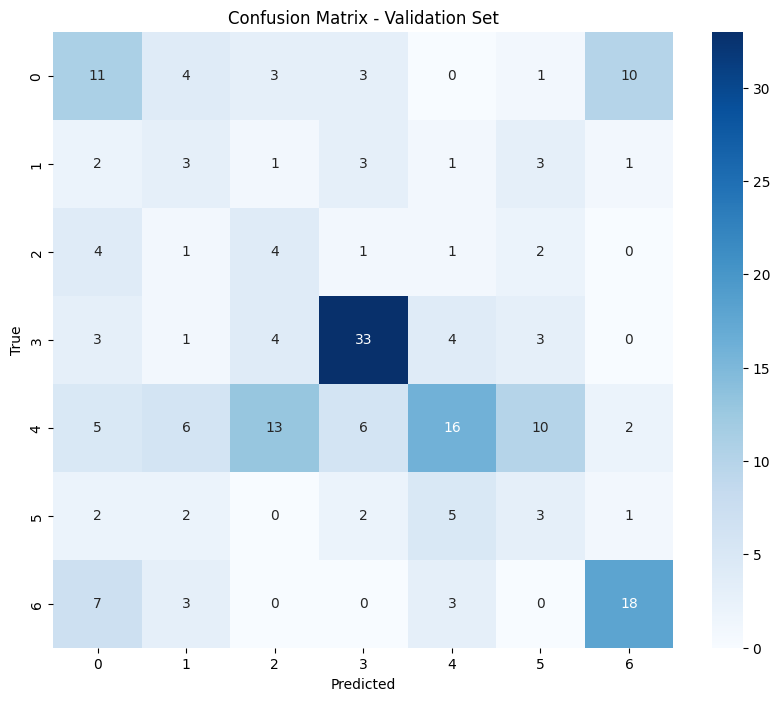

c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-pa

Training Accuracy: 0.4238 ± 0.0308
Validation Accuracy: 0.4738 ± 0.0565
The model is not overfitting.

Tuning DecisionTree Model


c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=7. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-pa

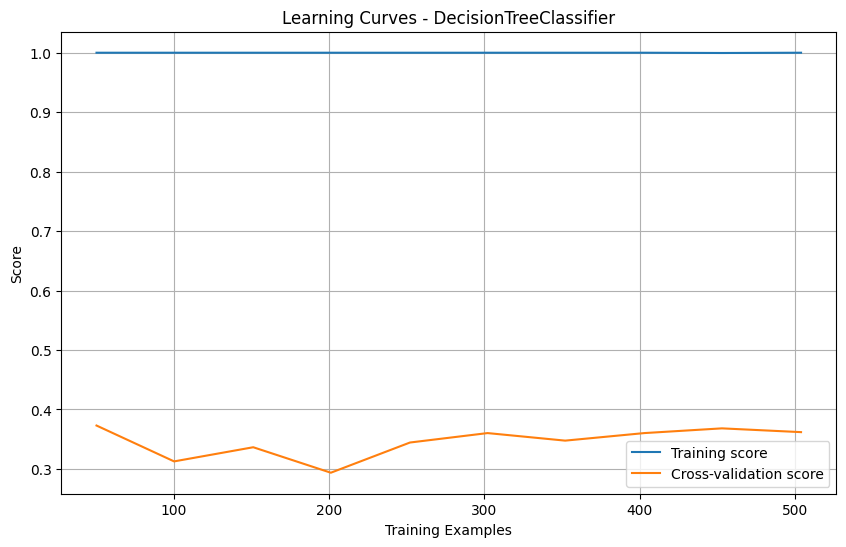

Best parameters for DecisionTreeClassifier:
{'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20, 'classifier__class_weight': 'balanced'}

Cross-validation scores:
accuracy: 0.3778
precision_weighted: 0.3879
recall_weighted: 0.3778
f1_weighted: 0.3792


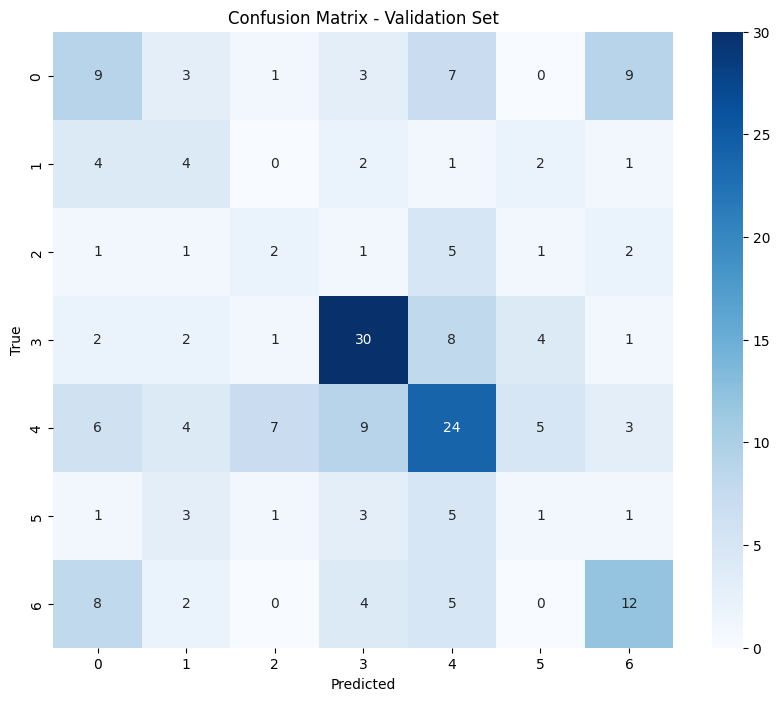

c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-pa

Training Accuracy: 0.3556 ± 0.0469
Validation Accuracy: 0.3554 ± 0.0492
The model is not overfitting.


c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(
c:\Users\amrit\env\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=8. All the features will be returned.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

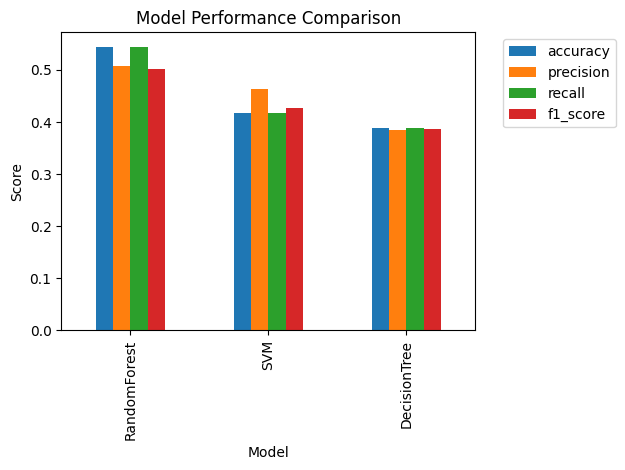


Best Model: RandomForest
Validation Accuracy: 0.5450


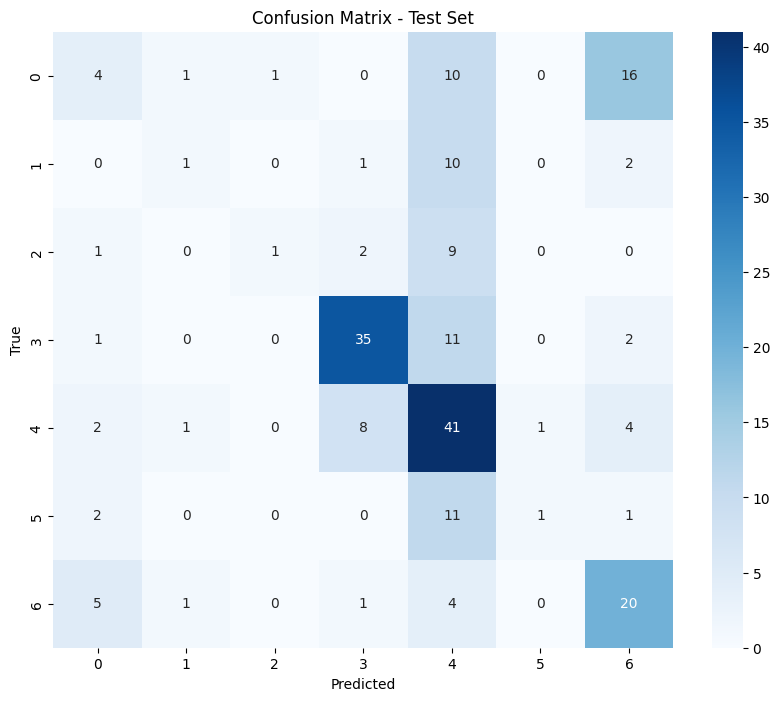


Test Set Metrics:
accuracy: 0.4882
precision: 0.4770
recall: 0.4882
f1_score: 0.4412


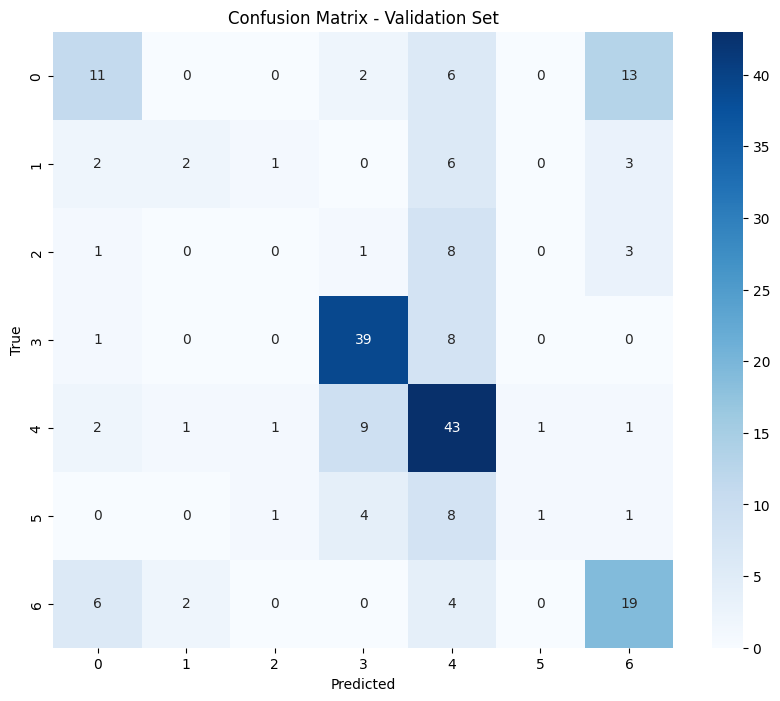

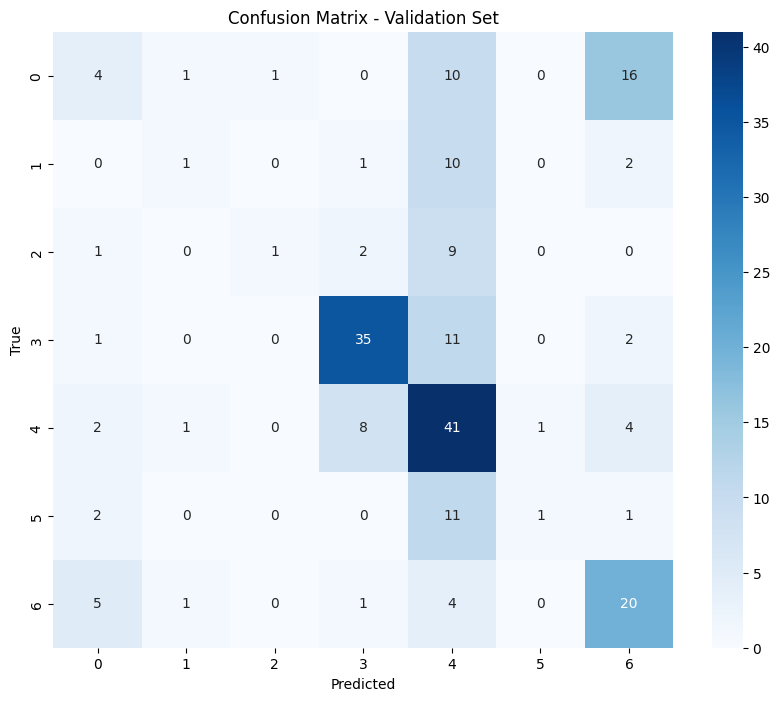

Model saved to ../model/best_emotion_model_RandomForest_dlib.pkl
Model metadata saved to ../model/best_emotion_model_RandomForest_metadata_dlib.json


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    learning_curve,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import joblib
import os
import json
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif


class MachineLearningWorkflow:
    def __init__(self, train_in, val_in, test_in, train_out, val_out, test_out):
        self.X_train = train_in
        self.X_val = val_in
        self.X_test = test_in
        self.y_train = train_out
        self.y_val = val_out
        self.y_test = test_out

    def plot_class_distribution(self):
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        sns.countplot(x=self.y_train)
        plt.title("Training Set Class Distribution")
        plt.xticks(rotation=45)

        plt.subplot(132)
        sns.countplot(x=self.y_val)
        plt.title("Validation Set Class Distribution")
        plt.xticks(rotation=45)

        plt.subplot(133)
        sns.countplot(x=self.y_test)
        plt.title("Test Set Class Distribution")
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    def create_preprocessing_pipeline(self):
        preprocessing_pipeline = Pipeline(
            [
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
                (
                    "pca",
                    PCA(n_components=0.95),
                ),  # Reduce dimensionality while retaining 95% variance
                (
                    "feature_selection",
                    SelectKBest(f_classif, k=100),
                ),  # Select top 100 features
            ]
        )
        return preprocessing_pipeline

    def plot_learning_curves(self, model, title):
        train_sizes, train_scores, val_scores = learning_curve(
            model,
            self.X_train,
            self.y_train,
            cv=5,
            train_sizes=np.linspace(0.1, 1.0, 10),
        )

        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), label="Training score")
        plt.plot(
            train_sizes, np.mean(val_scores, axis=1), label="Cross-validation score"
        )
        plt.xlabel("Training Examples")
        plt.ylabel("Score")
        plt.title(f"Learning Curves - {title}")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix - {title}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    def evaluate_model(self, model, X_val, y_val, plot_title="Validation Set"):
        y_pred = model.predict(X_val)
        metrics = {
            "accuracy": accuracy_score(y_val, y_pred),
            "precision": precision_score(y_val, y_pred, average="weighted"),
            "recall": recall_score(y_val, y_pred, average="weighted"),
            "f1_score": f1_score(y_val, y_pred, average="weighted"),
        }

        # Plot confusion matrix
        self.plot_confusion_matrix(y_val, y_pred, plot_title)

        return metrics

    def check_overfitting(self, model, X_train, y_train, X_val, y_val):
        train_scores = cross_val_score(
            model, X_train, y_train, cv=5, scoring="accuracy"
        )
        val_scores = cross_val_score(model, X_val, y_val, cv=5, scoring="accuracy")

        print(
            f"Training Accuracy: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}"
        )
        print(
            f"Validation Accuracy: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}"
        )

        if np.mean(train_scores) - np.mean(val_scores) > 0.1:
            print("Warning: The model is overfitting.")
        else:
            print("The model is not overfitting.")

    def tune_model_hyperparameters(self, model_class, param_grid):
        full_pipeline = Pipeline(
            [
                ("preprocessor", self.create_preprocessing_pipeline()),
                ("classifier", model_class()),
            ]
        )

        random_search = RandomizedSearchCV(
            full_pipeline,
            param_distributions=param_grid,
            n_iter=50,
            cv=5,
            scoring=[
                "accuracy",
                "precision_weighted",
                "recall_weighted",
                "f1_weighted",
            ],
            refit="accuracy",
            random_state=42,
            n_jobs=-1,
        )

        random_search.fit(self.X_train, self.y_train)

        # Plot learning curves for best model
        self.plot_learning_curves(random_search.best_estimator_, model_class.__name__)

        print(f"Best parameters for {model_class.__name__}:")
        print(random_search.best_params_)
        print("\nCross-validation scores:")
        for metric in random_search.scoring:
            print(
                f"{metric}: {random_search.cv_results_[f'mean_test_{metric}'][random_search.best_index_]:.4f}"
            )

        return random_search

    def train_and_compare_models(self):
        self.plot_class_distribution()

        models = {
            "RandomForest": {
                "class": RandomForestClassifier,
                "params": {
                    "classifier__n_estimators": [100, 200, 300, 400],
                    "classifier__max_depth": [10, 20, 30, None],
                    "classifier__min_samples_split": [2, 5, 10],
                    "classifier__max_features": ["sqrt", "log2"],
                    "classifier__class_weight": ["balanced", "balanced_subsample"],
                    "classifier__min_samples_leaf": [1, 2, 4],
                    "classifier__max_leaf_nodes": [None, 20, 50, 100],
                },
            },
            "SVM": {
                "class": SVC,
                "params": {
                    "classifier__kernel": ["rbf", "poly"],
                    "classifier__C": [0.1, 1, 10, 100],
                    "classifier__gamma": ["scale", "auto"],
                    "classifier__class_weight": ["balanced"],
                    "classifier__probability": [True],  # Enable probability estimates
                },
            },
            "DecisionTree": {
                "class": DecisionTreeClassifier,
                "params": {
                    "classifier__max_depth": [5, 10, 15, 20],
                    "classifier__min_samples_split": [2, 5, 10],
                    "classifier__min_samples_leaf": [1, 2, 4],
                    "classifier__class_weight": ["balanced"],
                },
            },
        }

        model_performances = {}
        for name, model_config in models.items():
            print(f"\nTuning {name} Model")
            tuned_model = self.tune_model_hyperparameters(
                model_config["class"], model_config["params"]
            )
            metrics = self.evaluate_model(
                tuned_model.best_estimator_, self.X_val, self.y_val
            )
            model_performances[name] = {
                "best_model": tuned_model.best_estimator_,
                "metrics": metrics,
            }

            # Check for overfitting
            self.check_overfitting(
                tuned_model.best_estimator_,
                self.X_train,
                self.y_train,
                self.X_val,
                self.y_val,
            )

        self.plot_model_comparison(model_performances)

        return model_performances

    def plot_model_comparison(self, model_performances):
        metrics_df = pd.DataFrame(
            {
                model_name: performance["metrics"]
                for model_name, performance in model_performances.items()
            }
        ).T

        plt.figure(figsize=(12, 6))
        metrics_df.plot(kind="bar")
        plt.title("Model Performance Comparison")
        plt.xlabel("Model")
        plt.ylabel("Score")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

    def select_best_model(self, model_performances):
        best_model_name = max(
            model_performances,
            key=lambda k: model_performances[k]["metrics"]["accuracy"],
        )
        best_model = model_performances[best_model_name]["best_model"]
        best_accuracy = model_performances[best_model_name]["metrics"]["accuracy"]

        print(f"\nBest Model: {best_model_name}")
        print(f"Validation Accuracy: {best_accuracy:.4f}")

        test_metrics = self.evaluate_model(
            best_model, self.X_test, self.y_test, "Test Set"
        )
        print("\nTest Set Metrics:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")

        return best_model, best_model_name

    def save_best_model(self, best_model, best_model_name, save_dir="../model/"):
        os.makedirs(save_dir, exist_ok=True)

        model_filename = f"best_emotion_model_{best_model_name}_dlib.pkl"
        model_path = os.path.join(save_dir, model_filename)
        joblib.dump(best_model, model_path)

        metadata = {
            "model_name": best_model_name,
            "creation_date": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
            "feature_count": self.X_train.shape[1],
            "training_samples": self.X_train.shape[0],
            "validation_metrics": self.evaluate_model(
                best_model, self.X_val, self.y_val
            ),
            "test_metrics": self.evaluate_model(best_model, self.X_test, self.y_test),
        }

        metadata_filename = f"best_emotion_model_{best_model_name}_metadata_dlib.json"
        metadata_path = os.path.join(save_dir, metadata_filename)

        with open(metadata_path, "w") as f:
            json.dump(metadata, f, indent=4)

        print(f"Model saved to {model_path}")
        print(f"Model metadata saved to {metadata_path}")


# Read the CSV file
csv_file = "../processed/face_landmarks.csv"
df = pd.read_csv(csv_file)

# Encode the emotion labels
label_encoder = LabelEncoder()
df["emotion"] = label_encoder.fit_transform(df["emotion"])

# Split the data into features and target
X = df.drop(columns=["emotion", "file_name"])
y = df["emotion"]

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split the training set into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

# Initialize the MachineLearningWorkflow
workflow = MachineLearningWorkflow(X_train, X_val, X_test, y_train, y_val, y_test)

# Train and compare models
model_performances = workflow.train_and_compare_models()

# Select the best model
best_model, best_model_name = workflow.select_best_model(model_performances)

# Save the best model
workflow.save_best_model(best_model, best_model_name)